<h1>TP – Classi cation Arborescente sur le Dataset

<h2>Partie 1 – Chargement & Exploration

In [29]:
## charger le dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# charger le dataset
titanic = pd.read_csv("6_train.csv")

# afficher les 5 premiers lignes
titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
#nombre total de passager 
print("nombre total de passager : ",titanic.shape[0])

#nombre de survivant
survived = titanic[titanic['Survived'] == 1]
print("nombre de survivant : ",survived.shape[0])

#calcul de proportion 
proportion = survived.shape[0]/titanic.shape[0]
print("proportion : ",proportion)

#les colonnes avec des valeurs manquantes 
missing_values = titanic.isnull().sum()
print("les colonnes avec des valeurs manquantes :\n",missing_values)

#le pourcentage des valeurs manquantes
missing_percentage = titanic.isnull().sum() / titanic.shape[0]
print("le pourcentage des valeurs manquantes :\n",missing_percentage[missing_percentage > 0])


nombre total de passager :  891
nombre de survivant :  342
proportion :  0.3838383838383838
les colonnes avec des valeurs manquantes :
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
le pourcentage des valeurs manquantes :
 Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64


<h2>Partie 2 – Nettoyage & Préparation</h2>

#### PassengerId = Primary Key donc ne fournit pas d'information
#### Name = Unique donc ne fournit pas d'information


In [31]:
#Imputez les valeurs manquantes Age par la médiane, Embarked par la modalité la plus fréquente
reformated_data = titanic.copy()
reformated_data['Age'] = titanic['Age'].fillna(titanic['Age'].median())
reformated_data['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode()[0])


#supprimer les colonnes : PassengerId , Name , Ticket , Cabin
reformated_data = reformated_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

#Ajout de la colonne title
# Extraction des titres
reformated_data['Title'] = titanic['Name'].str.extract('(Mr|Mrs|Miss|Master|Dr|Rev|Col|Major|Sir|Don|Lady|Countess|Jonkheer|Capt|Ms|Mme|Mlle)')
reformated_data['Title'] = reformated_data['Title'].fillna('Other')

print(reformated_data.groupby('Title').size())

# print(reformated_data[reformated_data['Title']== 'Capt'])




Title
Capt          1
Col          10
Countess      1
Don           1
Dr           10
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        180
Mlle          2
Mme           1
Mr          631
Ms            1
Rev           6
Sir           3
dtype: int64


#   Partie 3 – Encodage & Prétraitement

### 1 ère methode = LabelEncoder

In [32]:
from sklearn.preprocessing import LabelEncoder
#Encodez les variables catégorielles ( Sex, Embarked, Title ) à l’aide de LabelEncoder 
encodeur = LabelEncoder()
reformated_data['Sex'] = encodeur.fit_transform(reformated_data['Sex'])
reformated_data['Embarked'] = encodeur.fit_transform(reformated_data['Embarked'])
reformated_data['Title'] = encodeur.fit_transform(reformated_data['Title'])


print(reformated_data.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title
0         0       3    1  22.0      1      0   7.2500         2     12
1         1       1    0  38.0      1      0  71.2833         0     12
2         1       3    0  26.0      0      0   7.9250         2      9
3         1       1    0  35.0      1      0  53.1000         2     12
4         0       3    1  35.0      0      0   8.0500         2     12


### 2 ème méthode = OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Supposons que vous ayez déjà un DataFrame 'titanic' avec vos données
# Sélection des colonnes catégorielles à encoder
categorical_cols = ['Sex', 'Embarked', 'Title']

# Initialisation du OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' pour éviter la multicolinéarité

# Application de l'encodage
encoded_data = encoder.fit_transform(reformated_data[categorical_cols])

# Création d'un DataFrame avec les colonnes encodées
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(categorical_cols)
)

# Concaténation avec les données numériques
# D'abord, on supprime les colonnes catégorielles originales
titanic_encoded = pd.concat([
    reformated_data.drop(columns=categorical_cols),
    encoded_df
], axis=1)

# Affichage des premières lignes pour vérification
print(titanic_encoded.head())

### Standardisez Age et Fare avec StandardScaler


Pourquoi standardiser pour les arbres ?

 1 - Interprétation des caractéristiques :
Les coefficients d'importance des caractéristiques seront plus facilement comparables
Les valeurs de seuil dans les nœuds seront plus intuitives
 
 2 - Stabilité numérique :
Certaines implémentations d'arbres peuvent être plus stables avec des données normalisées
Réduit les problèmes d'arrondi numérique

 3 - Algorithmes dérivés :
Utile si vous utilisez des algorithmes basés sur les arbres qui utilisent des distances (comme le boosting)
Certaines optimisations comme XGBoost peuvent bénéficier de données normalisées

 4 - Combinaison avec d'autres modèles :
Si vous créez un modèle d'ensemble qui combine des arbres avec d'autres algorithmes sensibles à l'échelle

In [33]:
#Standardisez Age et Fare avec StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
reformated_data['Age'] = scaler.fit_transform(reformated_data[['Age']])
reformated_data['Fare'] = scaler.fit_transform(reformated_data[['Fare']])


In [34]:
from sklearn.model_selection import train_test_split

## Séparation des données en jeu d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(
    # stratify=reformated_data['Survived'], #pour garder les proportions de classes similaires dans train/test
    reformated_data.drop('Survived', axis=1), 
    reformated_data['Survived'], 
    random_state=42
)


print(f"Taille de l'ensemble d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test : {X_test.shape[0]} échantillons")
print(f"Proportion de survie dans l'entraînement : {y_train.mean():.2%}")
print(f"Proportion de survie dans le test : {y_test.mean():.2%}")

Taille de l'ensemble d'entraînement : 668 échantillons
Taille de l'ensemble de test : 223 échantillons
Proportion de survie dans l'entraînement : 37.87%
Proportion de survie dans le test : 39.91%


## Partie 4 – Visualisation & Analyse Exploratoire

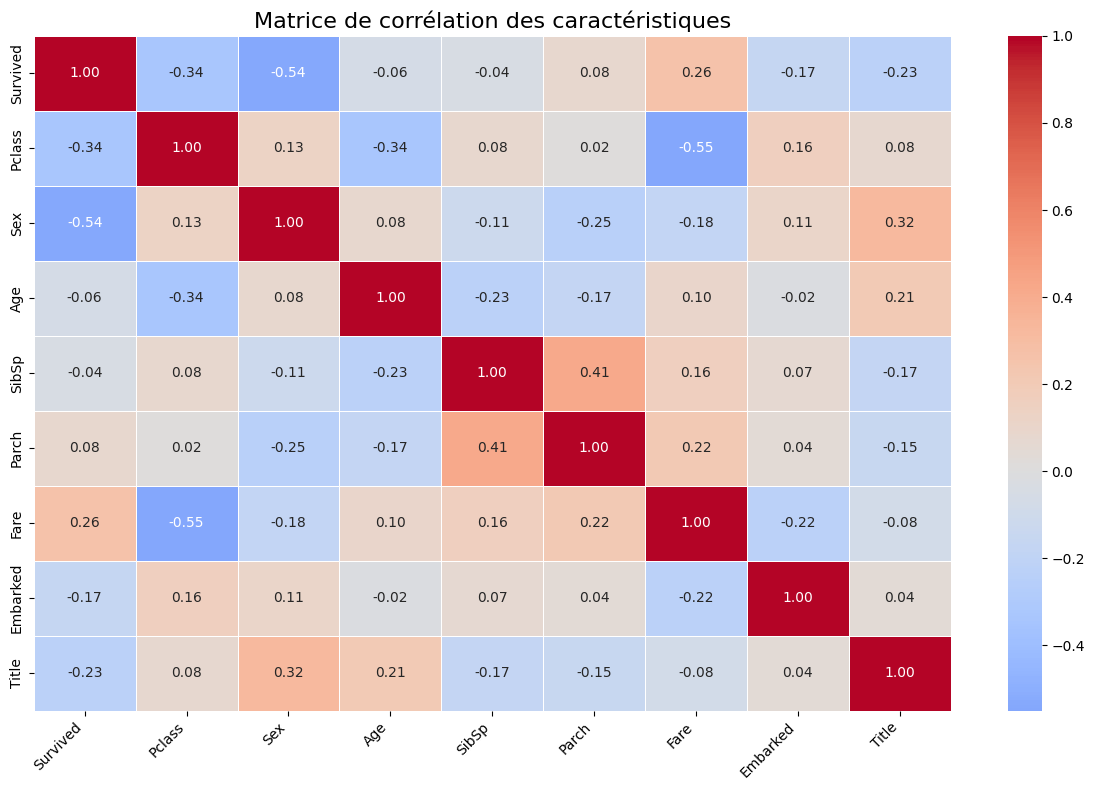


Corrélations avec Survived :
Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Embarked   -0.167675
Title      -0.234564
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul de la matrice de corrélation
correlation_matrix = reformated_data.corr(numeric_only=True)

# Création de la heatmap
plt.figure(figsize=(12, 8))
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Pour ne montrer que la moitié inférieure
sns.heatmap(correlation_matrix, 
            # mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt=".2f",
            linewidths=0.5)

plt.title('Matrice de corrélation des caractéristiques', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Afficher les corrélations avec Survived par ordre décroissant
survived_corr = correlation_matrix['Survived'].sort_values(ascending=False)
print("\nCorrélations avec Survived :")
print(survived_corr)

In [ ]:
# def plot_survival_rate_by(feature, df):
#     plt.figure(figsize=(8, 6))
#     survival = df.groupby(feature)['Survived'].mean().sort_values(ascending=False)
#     ax = sns.barplot(x=survival.index, y=survival.values, palette="pastel")
#     plt.title(f'Taux de survie par {feature}', fontsize=14)
#     plt.ylim(0, 1)
#     for p in ax.patches:
#         ax.annotate(f'{p.get_height():.1%}',
#                     (p.get_x() + p.get_width() / 2., p.get_height()),
#                     ha='center', va='bottom', fontsize=11, color='black',
#                     xytext=(0, 5), textcoords='offset points')
#     plt.show()

# plot_survival_rate_by('Sex', reformated_data)
# plot_survival_rate_by('Pclass', reformated_data)
# plot_survival_rate_by('Embarked', reformated_data)
# plot_survival_rate_by('Title', reformated_data)



In [24]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Configuration de l'affichage
# # plt.style.use('seaborn')
# sns.set_palette("pastel")
# plt.figure(figsize=(18, 14))

# # 1. Taux de survie par Sexe
# plt.subplot(2, 2, 1)
# sex_survival = reformated_data.groupby('Sex')['Survived'].mean().sort_values(ascending=False)
# sex_mapping = dict(zip(encodeur.classes_, encodeur.transform(encodeur.classes_)))
# inv_sex_mapping = {v: k for k, v in sex_mapping.items()}
# reformated_data['Sex'] = reformated_data['Sex'].map(inv_sex_mapping)


# ax = sns.barplot(x=sex_survival.index, y=sex_survival.values)
# plt.title('Taux de survie par Sexe', fontsize=14)
# plt.ylim(0, 1)
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.1%}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=12, color='black', 
#                 xytext=(0, 10), textcoords='offset points')

# # 2. Taux de survie par Classe
# plt.subplot(2, 2, 2)
# class_survival = reformated_data.groupby('Pclass')['Survived'].mean().sort_index(ascending=False)
# ax = sns.barplot(x=class_survival.index, y=class_survival.values, order=[1, 2, 3])
# plt.title('Taux de survie par Classe', fontsize=14)
# plt.ylim(0, 1)
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.1%}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=12, color='black', 
#                 xytext=(0, 10), textcoords='offset points')

# # 3. Taux de survie par Port d'embarquement
# plt.subplot(2, 2, 3)
# embarked_survival = reformated_data.groupby('Embarked')['Survived'].mean().sort_values(ascending=False)
# ax = sns.barplot(x=embarked_survival.index, y=embarked_survival.values)
# plt.title('Taux de survie par Port d\'embarquement', fontsize=14)
# plt.ylim(0, 1)
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.1%}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=12, color='black', 
#                 xytext=(0, 10), textcoords='offset points')

# # 4. Taux de survie par Titre
# plt.subplot(2, 2, 4)
# title_survival = reformated_data.groupby('Title')['Survived'].mean().sort_values(ascending=False)
# ax = sns.barplot(x=title_survival.index, y=title_survival.values)
# plt.title('Taux de survie par Titre', fontsize=14)
# plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 1)
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.1%}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=10, color='black', 
#                 xytext=(0, 10), textcoords='offset points', rotation=45)

# plt.tight_layout()
# plt.show()

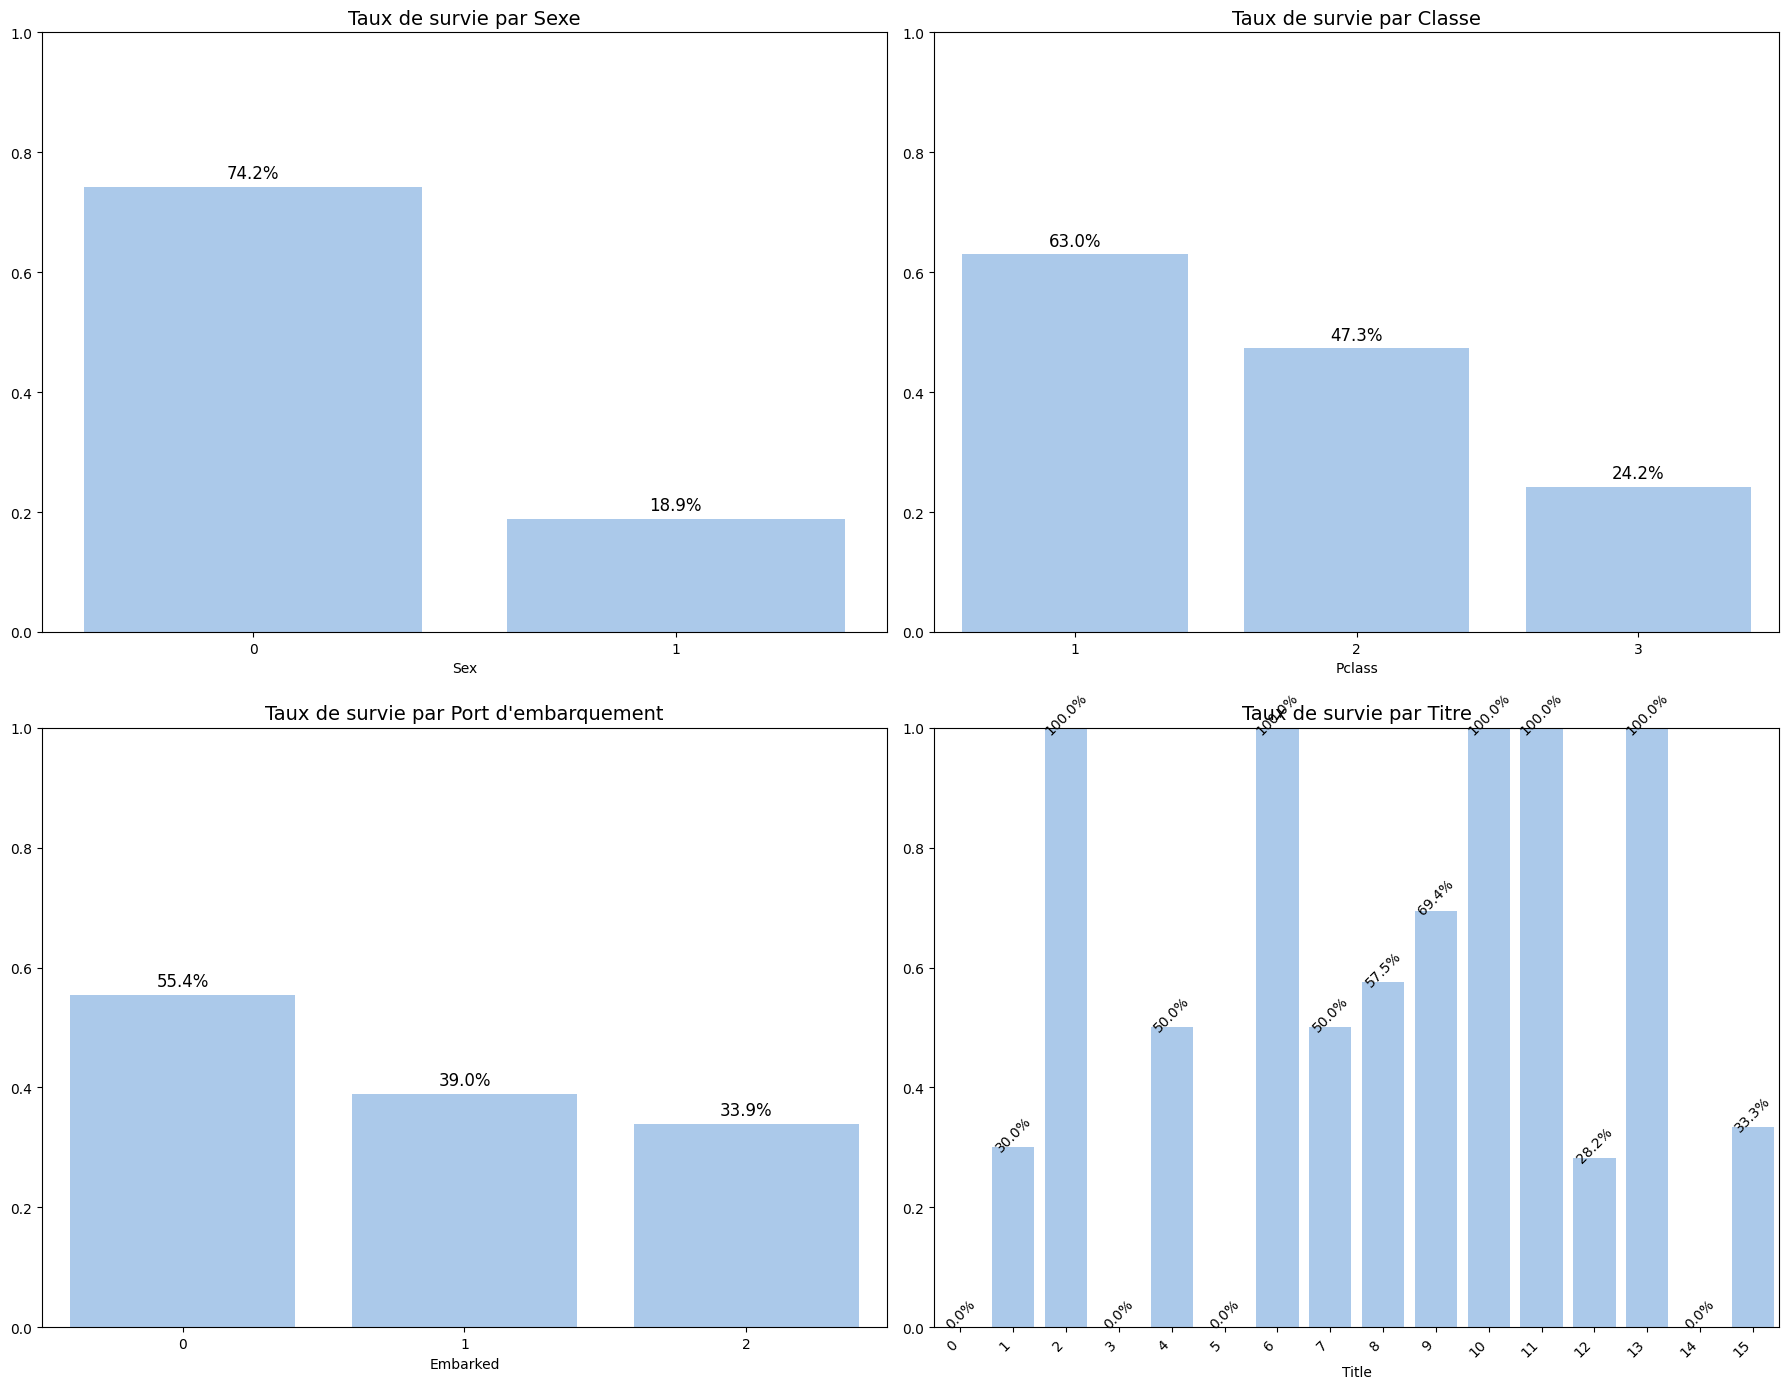

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sns.set_palette("pastel")
plt.figure(figsize=(18, 14))


# 1. Taux de survie par Sexe
plt.subplot(2, 2, 1)
sex_survival = reformated_data.groupby('Sex')['Survived'].mean().sort_values(ascending=False)
ax = sns.barplot(x=sex_survival.index, y=sex_survival.values)
plt.title('Taux de survie par Sexe', fontsize=14)
plt.ylim(0, 1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 10), textcoords='offset points')

# 2. Taux de survie par Classe
plt.subplot(2, 2, 2)
class_survival = reformated_data.groupby('Pclass')['Survived'].mean().sort_index(ascending=False)
ax = sns.barplot(x=class_survival.index, y=class_survival.values, order=[1, 2, 3])
plt.title('Taux de survie par Classe', fontsize=14)
plt.ylim(0, 1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 10), textcoords='offset points')

# 3. Taux de survie par Port d'embarquement
plt.subplot(2, 2, 3)
embarked_survival = reformated_data.groupby('Embarked')['Survived'].mean().sort_values(ascending=False)
ax = sns.barplot(x=embarked_survival.index, y=embarked_survival.values)
plt.title('Taux de survie par Port d\'embarquement', fontsize=14)
plt.ylim(0, 1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 10), textcoords='offset points')

# 4. Taux de survie par Titre
plt.subplot(2, 2, 4)
title_survival = reformated_data.groupby('Title')['Survived'].mean().sort_values(ascending=False)
ax = sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Taux de survie par Titre', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 10), textcoords='offset points', rotation=45)

plt.tight_layout()
plt.show()


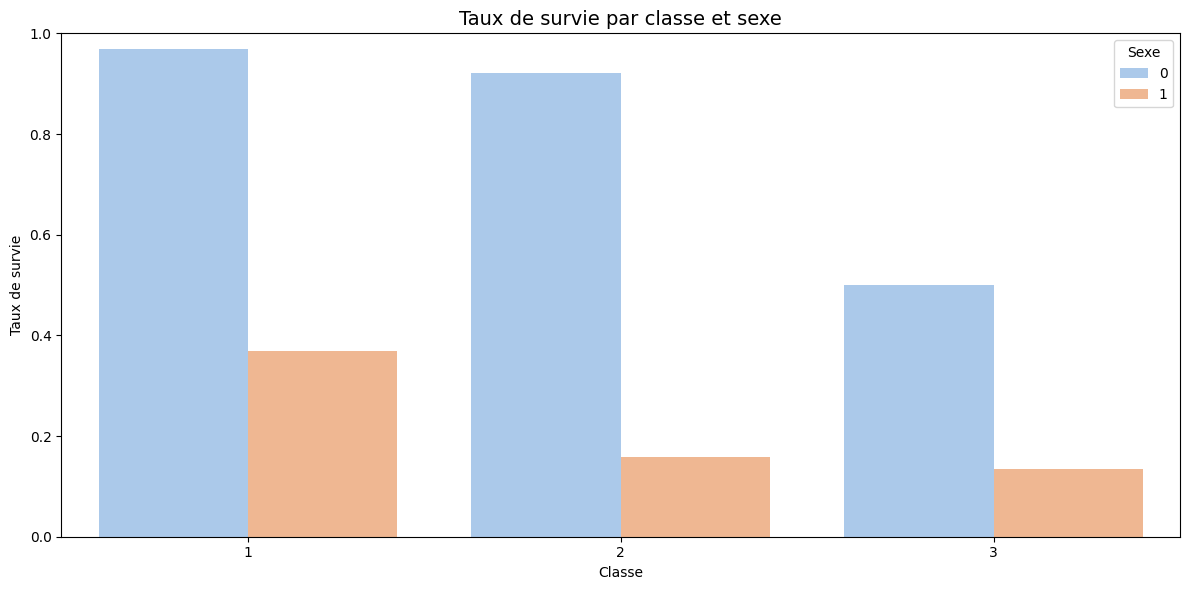

In [64]:
# Analyse plus détaillée : taux de survie par sexe et classe
plt.figure(figsize=(12, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=reformated_data, errorbar=None)
plt.title('Taux de survie par classe et sexe', fontsize=14)
plt.ylabel('Taux de survie')
plt.xlabel('Classe')
plt.ylim(0, 1)
plt.legend(title='Sexe')
plt.tight_layout()
plt.show()

Conclusion : femme plus de chance de survie

## Partie 5 – Arbre de Décision


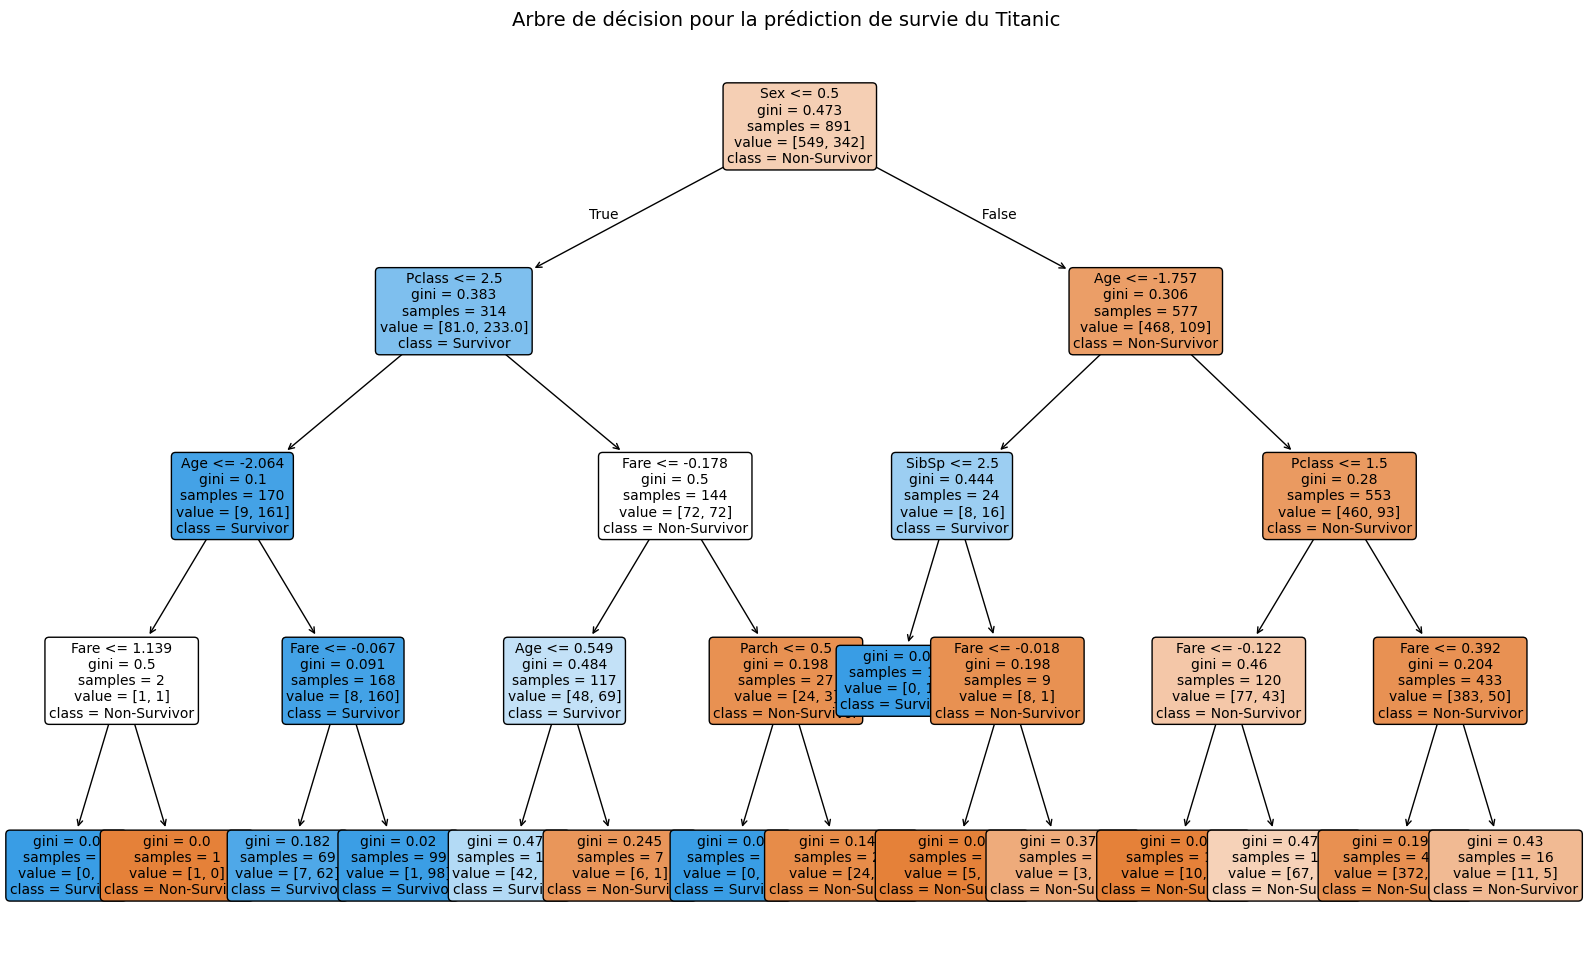

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

# Encodage des variables catégorielles si nécessaire
# (à exécuter uniquement si ce n'est pas déjà fait)
le = LabelEncoder()
categorical_cols = ['Sex', 'Embarked', 'Title']
for col in categorical_cols:
    reformated_data[col] = le.fit_transform(reformated_data[col])

# Séparation des caractéristiques et de la cible
X = reformated_data.drop('Survived', axis=1)
y = reformated_data['Survived']

# Création et entraînement du modèle
dt_classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_classifier.fit(X, y)

# Visualisation de l'arbre
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier, 
          feature_names=X.columns, 
          class_names=['Non-Survivor', 'Survivor'],
          filled=True, 
          rounded=True,
        #   proportion=True,
          fontsize=10)
plt.title("Arbre de décision pour la prédiction de survie du Titanic", fontsize=14)
plt.show()

=== Métriques de performance ===
Accuracy: 0.8206
Précision: 0.8267
Rappel: 0.6966
F1-score: 0.7561
AUC-ROC: 0.8828


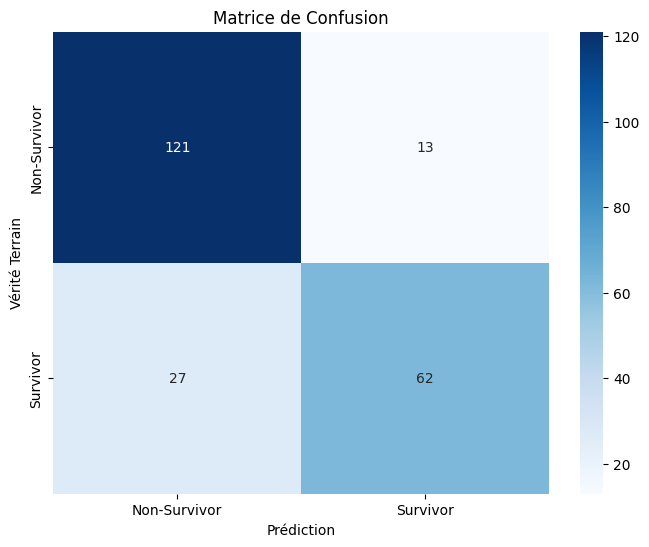

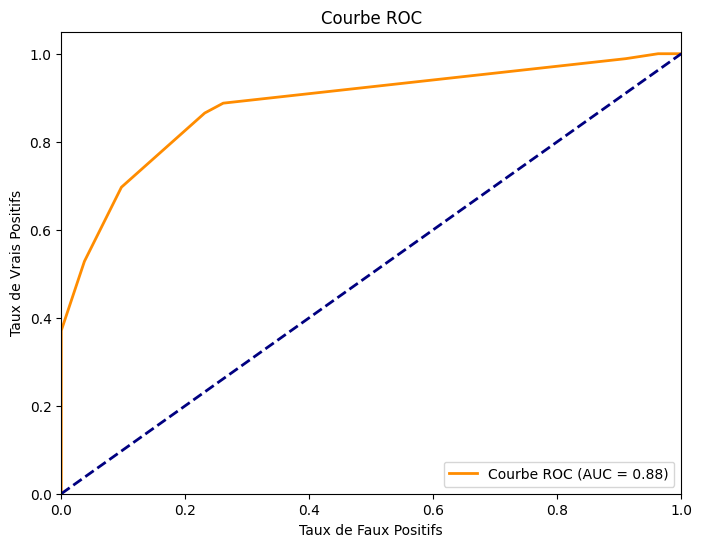


=== Rapport de classification ===
              precision    recall  f1-score   support

Non-Survivor       0.82      0.90      0.86       134
    Survivor       0.83      0.70      0.76        89

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



In [11]:
# from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
#                              f1_score, confusion_matrix, roc_curve, roc_auc_score, 
#                              ConfusionMatrixDisplay, RocCurveDisplay)
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Prédictions
# y_pred = dt_classifier.predict(X_test)
# y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# # 1. Métriques de base
# print("=== Métriques de performance ===")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"Précision: {precision_score(y_test, y_pred):.4f}")
# print(f"Rappel: {recall_score(y_test, y_pred):.4f}")
# print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
# print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# # 2. Matrice de confusion
# plt.figure(figsize=(8, 6))
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['Non-Survivor', 'Survivor'],
#             yticklabels=['Non-Survivor', 'Survivor'])
# plt.title('Matrice de Confusion')
# plt.ylabel('Vérité Terrain')
# plt.xlabel('Prédiction')
# plt.show()

# # 3. Courbe ROC
# plt.figure(figsize=(8, 6))
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# plt.plot(fpr, tpr, color='darkorange', lw=2, 
#          label=f'Courbe ROC (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Taux de Faux Positifs')
# plt.ylabel('Taux de Vrais Positifs')
# plt.title('Courbe ROC')
# plt.legend(loc="lower right")
# plt.show()

# # 4. Rapport de classification
# from sklearn.metrics import classification_report
# print("\n=== Rapport de classification ===")
# print(classification_report(y_test, y_pred, 
#                            target_names=['Non-Survivor', 'Survivor']))

Accuracy      : 80.72%
Précision     : 80.26%
Rappel        : 68.54%
F1-score      : 73.94%


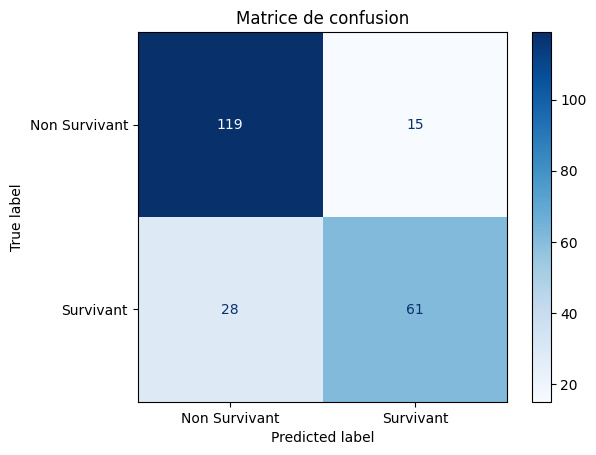

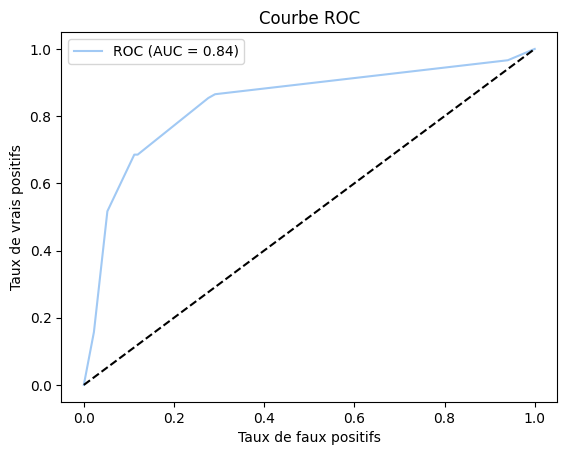

In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# 1. Refaire une séparation des données (train/test)
X = reformated_data.drop('Survived', axis=1)
y = reformated_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    # test_size=0.25, 
    # stratify=y, 
    random_state=42
)

# 2. Entraîner à nouveau le modèle
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# 3. Prédictions et métriques
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Pour la courbe ROC

# Métriques classiques
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy      : {acc:.2%}")
print(f"Précision     : {prec:.2%}")
print(f"Rappel        : {rec:.2%}")
print(f"F1-score      : {f1:.2%}")

# 5. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Survivant", "Survivant"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion")
plt.show()

# 6. Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()



## Partie 6 – Random Forest

In [12]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Création et entraînement du modèle Random Forest
# rf_classifier = RandomForestClassifier(
#     n_estimators=100,       # Nombre d'arbres
#     max_depth=4,            # Profondeur maximale des arbres
#     random_state=42,        # Pour la reproductibilité
#     n_jobs=-1,             # Utilisation de tous les cœurs du processeur
#     class_weight='balanced' # Gestion du déséquilibre des classes
# )

# # Entraînement du modèle
# rf_classifier.fit(X_train, y_train)

# # Prédiction sur l'ensemble de test
# y_pred_rf = rf_classifier.predict(X_test)
# y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

# # Évaluation du modèle
# print("=== Métriques de performance ===")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
# print(f"Précision: {precision_score(y_test, y_pred_rf):.4f}")
# print(f"Rappel: {recall_score(y_test, y_pred_rf):.4f}")
# print(f"F1-score: {f1_score(y_test, y_pred_rf):.4f}")
# print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# # Affichage des caractéristiques les plus importantes
# feature_importance = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': rf_classifier.feature_importances_
# }).sort_values('importance', ascending=False)

# print("\n=== Importance des caractéristiques ===")
# print(feature_importance)

# # Affichage du rapport de classification
# print("\n=== Rapport de classification ===")
# print(classification_report(y_test, y_pred_rf, 
#                           target_names=['Non-Survivor', 'Survivor']))

=== Métriques de performance ===
Accuracy: 0.7982
Précision: 0.7391
Rappel: 0.7640
F1-score: 0.7514
AUC-ROC: 0.8866

=== Importance des caractéristiques ===
    feature  importance
1       Sex    0.437383
5      Fare    0.156775
0    Pclass    0.123205
7     Title    0.111724
2       Age    0.072300
3     SibSp    0.046217
4     Parch    0.026568
6  Embarked    0.025829

=== Rapport de classification ===
              precision    recall  f1-score   support

Non-Survivor       0.84      0.82      0.83       134
    Survivor       0.74      0.76      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

# Création et entraînement du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


# Prédictions
# y_pred_rf = rf_model.predict(X_test)
# y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# # Métriques
# acc = accuracy_score(y_test, y_pred_rf)
# prec = precision_score(y_test, y_pred_rf)
# rec = recall_score(y_test, y_pred_rf)
# f1 = f1_score(y_test, y_pred_rf)

# print("✅ Random Forest (100 arbres)")
# print(f"Accuracy      : {acc:.2%}")
# print(f"Précision     : {prec:.2%}")
# print(f"Rappel        : {rec:.2%}")
# print(f"F1-score      : {f1:.2%}")

# # 4. Matrice de confusion
# cm_rf = confusion_matrix(y_test, y_pred_rf)
# disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Non Survivant", "Survivant"])
# disp_rf.plot(cmap="Greens", values_format='d')
# plt.title("Matrice de confusion - Random Forest")
# plt.show()

# # 5 Courbe ROC
# fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
# roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.2f}", color='green')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel("Taux de faux positifs (FPR)")
# plt.ylabel("Taux de vrais positifs (TPR)")
# plt.title("Courbe ROC - Random Forest")
# plt.legend()
# plt.grid()
# plt.show()



RandomForestClassifier(random_state=42)

In [48]:
# Calcul des scores pour le DecisionTree (déjà fait plus haut)
y_pred_tree = clf.predict(X_test)
y_prob_tree = clf.predict_proba(X_test)[:, 1]

# Decision Tree metrics
metrics_tree = {
    "Accuracy": accuracy_score(y_test, y_pred_tree),
    "Precision": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1-score": f1_score(y_test, y_pred_tree),
    "AUC ROC": roc_auc_score(y_test, y_prob_tree)
}

# Random Forest metrics (déjà fait)
metrics_rf = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-score": f1_score(y_test, y_pred_rf),
    "AUC ROC": roc_auc_score(y_test, y_prob_rf)
}

# Affichage comparatif
print("🔎 Comparaison des performances\n")
print(f"{'Métrique':<10} | {'Decision Tree':>14} | {'Random Forest':>14}")
print("-" * 45)
for metric in metrics_tree:
    print(f"{metric:<10} | {metrics_tree[metric]:>14.2%} | {metrics_rf[metric]:>14.2%}")


🔎 Comparaison des performances

Métrique   |  Decision Tree |  Random Forest
---------------------------------------------
Accuracy   |         80.72% |         81.17%
Precision  |         80.26% |         76.40%
Recall     |         68.54% |         76.40%
F1-score   |         73.94% |         76.40%
AUC ROC    |         83.95% |         87.53%


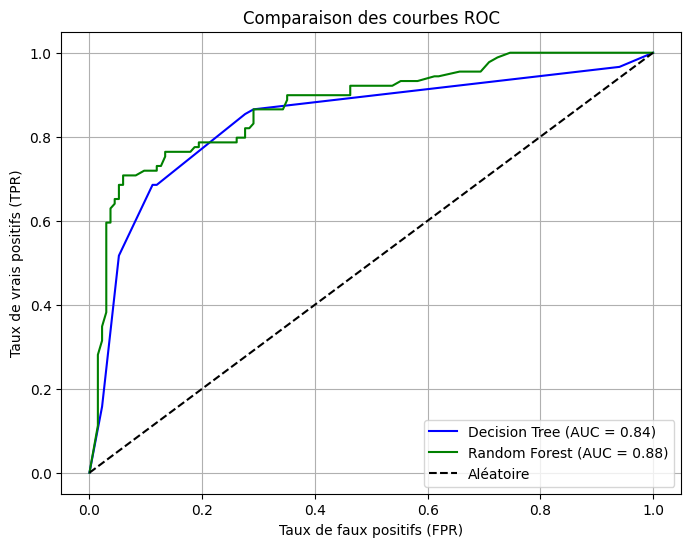

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Prédictions probabilistes
y_prob_tree = clf.predict_proba(X_test)[:, 1]  # Decision Tree
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Random Forest

# Calcul des courbes ROC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Calcul des AUC
auc_tree = roc_auc_score(y_test, y_prob_tree)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Tracé des courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='green')

# Diagonale (cas aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')

plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Comparaison des courbes ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


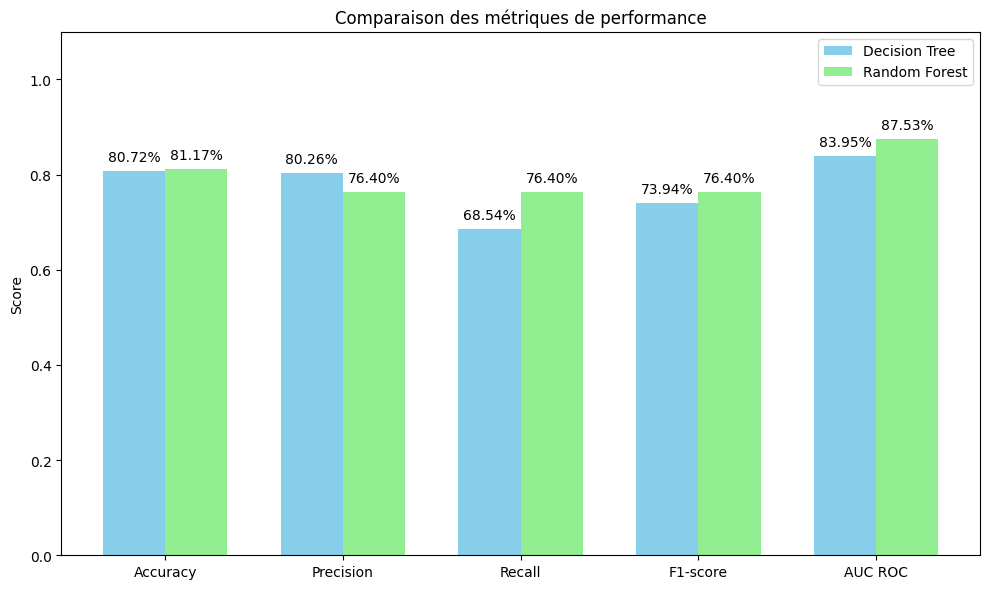

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que vous avez déjà ces métriques calculées :
metrics_tree = {
    "Accuracy": accuracy_score(y_test, y_pred_tree),
    "Precision": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1-score": f1_score(y_test, y_pred_tree),
    "AUC ROC": roc_auc_score(y_test, y_prob_tree)
}

metrics_rf = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-score": f1_score(y_test, y_pred_rf),
    "AUC ROC": roc_auc_score(y_test, y_prob_rf)
}

metrics_names = list(metrics_tree.keys())
tree_scores = [metrics_tree[m] for m in metrics_names]
rf_scores = [metrics_rf[m] for m in metrics_names]

x = np.arange(len(metrics_names))  # positions des groupes
width = 0.35  # largeur des barres

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, tree_scores, width, label='Decision Tree', color='skyblue')
bars2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest', color='lightgreen')

# Ajouter les valeurs au-dessus des barres
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_values(bars1)
add_values(bars2)

# Configuration des axes
ax.set_ylabel('Score')
ax.set_title('Comparaison des métriques de performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()


In [49]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# # Fonction pour calculer les métriques
# def evaluate_model(model, X, y, model_name):
#     y_pred = model.predict(X)
#     y_proba = model.predict_proba(X)[:, 1]
    
#     metrics = {
#         'Modèle': model_name,
#         'Accuracy': accuracy_score(y, y_pred),
#         'Précision': precision_score(y, y_pred),
#         'Recall': recall_score(y, y_pred),
#         'F1-score': f1_score(y, y_pred),
#         'AUC-ROC': roc_auc_score(y, y_proba)
#     }
#     return metrics, y_pred, y_proba

# # Évaluation des modèles
# dt_metrics, y_pred_dt, y_proba_dt = evaluate_model(dt_classifier, X_test, y_test, "Arbre de Décision")
# rf_metrics, y_pred_rf, y_proba_rf = evaluate_model(rf_classifier, X_test, y_test, "Random Forest")

# # Création d'un DataFrame pour la comparaison
# comparison_df = pd.DataFrame([dt_metrics, rf_metrics])
# print("=== Comparaison des modèles ===")
# print(comparison_df.set_index('Modèle').T)

# # 1. Graphique des métriques
# plt.figure(figsize=(12, 6))
# metrics_to_plot = ['Accuracy', 'Précision', 'Rappel', 'F1-score', 'AUC-ROC']
# x = np.arange(len(metrics_to_plot))
# width = 0.35

# fig, ax = plt.subplots(figsize=(14, 7))
# rects1 = ax.bar(x - width/2, dt_metrics[1:], width, label='Arbre de Décision')
# rects2 = ax.bar(x + width/2, rf_metrics[1:], width, label='Random Forest')

# ax.set_ylabel('Scores')
# ax.set_title('Comparaison des performances des modèles')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_to_plot)
# ax.legend()

# # Ajout des valeurs sur les barres
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.3f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.tight_layout()
# plt.show()

# # 2. Matrices de confusion côte à côte
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# # Matrice de confusion pour l'arbre de décision
# cm_dt = confusion_matrix(y_test, y_pred_dt)
# disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
#                                display_labels=['Non-Survivor', 'Survivor'])
# disp_dt.plot(ax=ax1, cmap='Blues')
# ax1.set_title('Arbre de Décision')

# # Matrice de confusion pour la Random Forest
# cm_rf = confusion_matrix(y_test, y_pred_rf)
# disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
#                                display_labels=['Non-Survivor', 'Survivor'])
# disp_rf.plot(ax=ax2, cmap='Blues')
# ax2.set_title('Random Forest')

# plt.tight_layout()
# plt.show()

# # 3. Courbes ROC
# plt.figure(figsize=(10, 8))

# # Courbe ROC pour l'arbre de décision
# fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
# roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
# plt.plot(fpr_dt, tpr_dt, label=f'Arbre de Décision (AUC = {roc_auc_dt:.3f})')

# # Courbe ROC pour la Random Forest
# fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
# roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
# plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# # Ligne de référence
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Taux de Faux Positifs')
# plt.ylabel('Taux de Vrais Positifs')
# plt.title('Courbes ROC comparées')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()

=== Les 3 variables les plus importantes ===
  Caractéristique  Importance
1             Sex    0.437383
5            Fare    0.156775
0          Pclass    0.123205


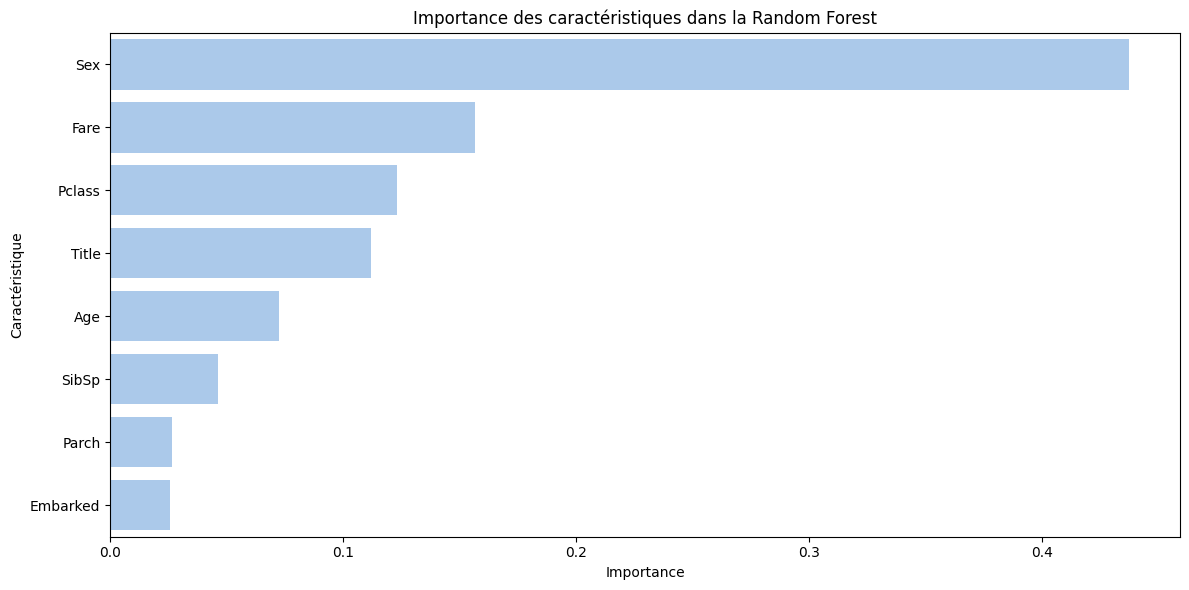

In [50]:
# # Récupération des importances des caractéristiques
# importances = rf_classifier.feature_importances_
# features = X_train.columns

# # Création d'un DataFrame pour une meilleure visualisation
# feature_importance_df = pd.DataFrame({
#     'Caractéristique': features,
#     'Importance': importances
# }).sort_values('Importance', ascending=False)

# # Affichage des 3 variables les plus importantes
# top_3_features = feature_importance_df.head(3)
# print("=== Les 3 variables les plus importantes ===")
# print(top_3_features)

# # Visualisation des importances
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Importance', y='Caractéristique', 
#             data=feature_importance_df.sort_values('Importance', ascending=False))
# plt.title('Importance des caractéristiques dans la Random Forest')
# plt.tight_layout()
# plt.show()

In [51]:
# Récupération des importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Associer noms et importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 3 plus importantes
print("🔍 Les 3 variables les plus importantes :")
print(feature_importance_df.head(3))


🔍 Les 3 variables les plus importantes :
  Feature  Importance
5    Fare    0.263678
1     Sex    0.237397
2     Age    0.225909


#  Partie 7 – Analyse & Optimisation

max_depth=1: Train accuracy=0.7874, Test accuracy=0.7848
max_depth=2: Train accuracy=0.8024, Test accuracy=0.7758
max_depth=3: Train accuracy=0.8323, Test accuracy=0.8027
max_depth=4: Train accuracy=0.8428, Test accuracy=0.8072
max_depth=5: Train accuracy=0.8503, Test accuracy=0.7982
max_depth=6: Train accuracy=0.8578, Test accuracy=0.7668
max_depth=7: Train accuracy=0.8757, Test accuracy=0.8117
max_depth=8: Train accuracy=0.8967, Test accuracy=0.7713
max_depth=9: Train accuracy=0.9132, Test accuracy=0.7892
max_depth=10: Train accuracy=0.9326, Test accuracy=0.7623


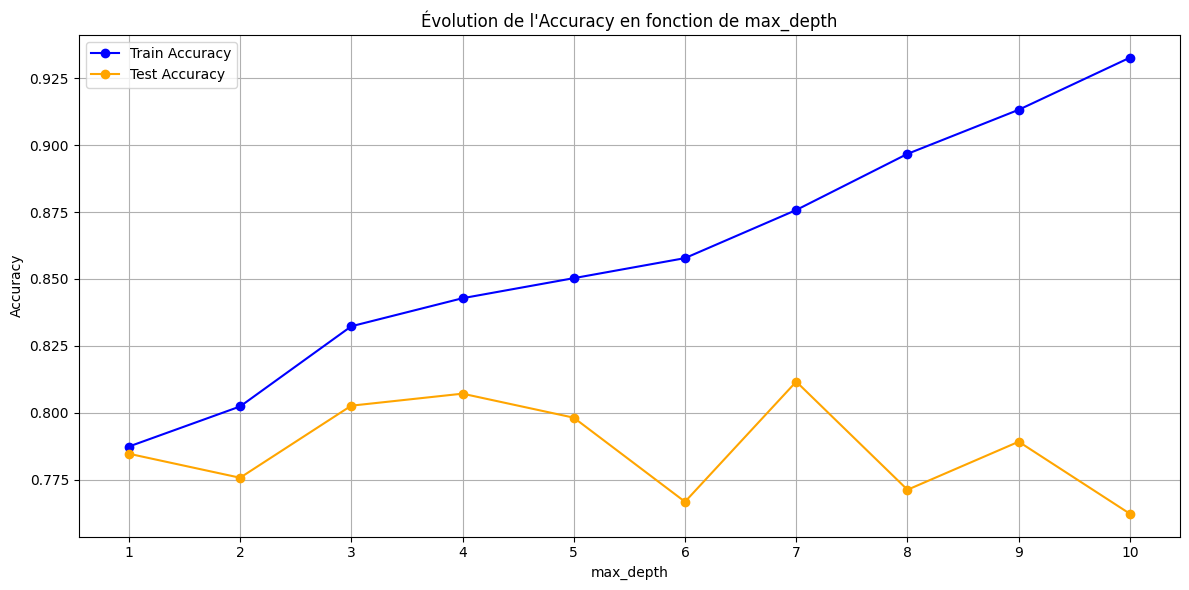

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []
depth_range = range(1, 11)

for depth in depth_range:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des accuracies
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

    print(f"max_depth={depth}: Train accuracy={accuracy_score(y_train, y_train_pred):.4f}, Test accuracy={accuracy_score(y_test, y_test_pred):.4f}")

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(depth_range, train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.plot(depth_range, test_accuracies, label="Test Accuracy", marker='o', color='orange')

plt.title("Évolution de l'Accuracy en fonction de max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.xticks(depth_range)
# plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


max_depth=1: Train=0.7874, Test=0.7848, Écart=0.0027
max_depth=2: Train=0.8024, Test=0.7758, Écart=0.0266
max_depth=3: Train=0.8323, Test=0.8027, Écart=0.0296
max_depth=4: Train=0.8428, Test=0.8072, Écart=0.0356
max_depth=5: Train=0.8503, Test=0.7982, Écart=0.0521
max_depth=6: Train=0.8578, Test=0.7668, Écart=0.0910
max_depth=7: Train=0.8757, Test=0.8117, Écart=0.0641
max_depth=8: Train=0.8967, Test=0.7713, Écart=0.1254
max_depth=9: Train=0.9132, Test=0.7892, Écart=0.1239
max_depth=10: Train=0.9326, Test=0.7623, Écart=0.1703


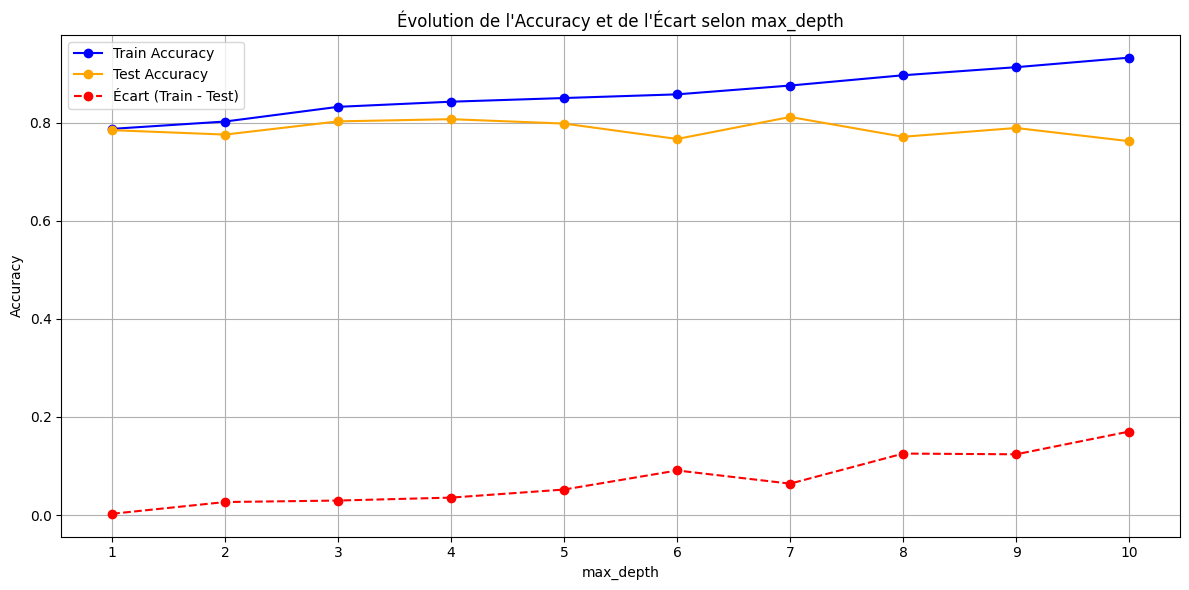

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []
gap_accuracies = []
depth_range = range(1, 11)

for depth in depth_range:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    gap = train_acc - test_acc

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    gap_accuracies.append(gap)

    print(f"max_depth={depth}: Train={train_acc:.4f}, Test={test_acc:.4f}, Écart={gap:.4f}")

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(depth_range, train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.plot(depth_range, test_accuracies, label="Test Accuracy", marker='o', color='orange')
plt.plot(depth_range, gap_accuracies, label="Écart (Train - Test)", marker='o', color='red', linestyle='--')

plt.title("Évolution de l'Accuracy et de l'Écart selon max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.xticks(depth_range)
# plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



🌳 Decision Tree:
  Moyenne accuracy : 0.8115
  Écart-type       : 0.0675

🌲 Random Forest:
  Moyenne accuracy : 0.8010
  Écart-type       : 0.0439

📊 Coefficient de variation (std / mean):
  Decision Tree : 0.0831
  Random Forest : 0.0548
✅ Random Forest est 1.52 fois plus stable que Decision Tree.


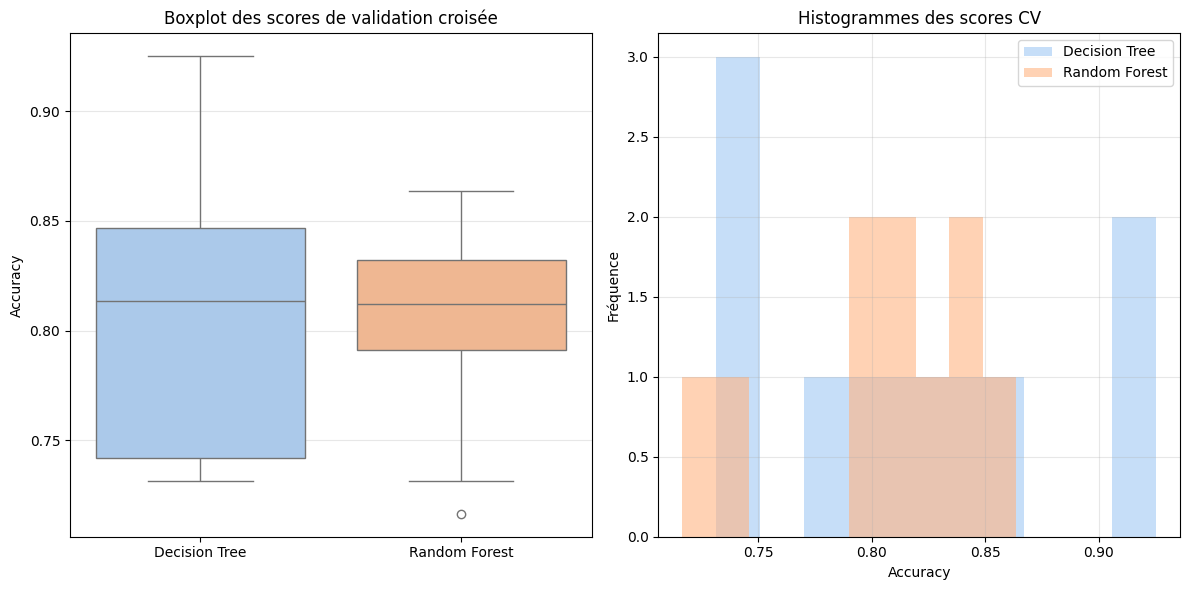

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Modèles
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Données d'entraînement
# x = X_train, y = y_train   (si ce n’est pas déjà défini)
x = X_train
y = y_train

# Validation croisée à 10 plis
n_folds = 10
dt_scores = cross_val_score(dt_model, x, y, cv=n_folds, scoring='accuracy')
rf_scores = cross_val_score(rf_model, x, y, cv=n_folds, scoring='accuracy')

# Statistiques
print("🌳 Decision Tree:")
print(f"  Moyenne accuracy : {dt_scores.mean():.4f}")
print(f"  Écart-type       : {dt_scores.std():.4f}")

print("\n🌲 Random Forest:")
print(f"  Moyenne accuracy : {rf_scores.mean():.4f}")
print(f"  Écart-type       : {rf_scores.std():.4f}")

# Coefficient de variation
cv_dt = dt_scores.std() / dt_scores.mean()
cv_rf = rf_scores.std() / rf_scores.mean()

print("\n📊 Coefficient de variation (std / mean):")
print(f"  Decision Tree : {cv_dt:.4f}")
print(f"  Random Forest : {cv_rf:.4f}")

if cv_rf < cv_dt:
    print(f"✅ Random Forest est {cv_dt / cv_rf:.2f} fois plus stable que Decision Tree.")
else:
    print(f"✅ Decision Tree est {cv_rf / cv_dt:.2f} fois plus stable que Random Forest.")

# Visualisation
scores_df = pd.DataFrame({
    'Decision Tree': dt_scores,
    'Random Forest': rf_scores
})

plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=scores_df)
plt.title("Boxplot des scores de validation croisée")
plt.ylabel("Accuracy")
plt.grid(axis='y', alpha=0.3)

# Histogrammes
plt.subplot(1, 2, 2)
plt.hist(dt_scores, alpha=0.6, label='Decision Tree', bins=10)
plt.hist(rf_scores, alpha=0.6, label='Random Forest', bins=10)
plt.title("Histogrammes des scores CV")
plt.xlabel("Accuracy")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
